In [37]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import pandas as pd
import datetime as dt
import pydot
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
import sys

mask_directory = '/Users/kathum/Research/COPEX/sink_region_files/masks'
WAM_files = '/Volumes/LaCie_10TB_Keys_KH/era5/output/backtrack/co_altclimate_nfr_2000_2023/'
sink_region_name = 'nfr'

## Open Labels and Inputs

In [4]:
# MODIFY----------
label_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/nfr_daily_precip.csv'
input_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/nfr_daily_e_track.csv'
#-----------------

X = pd.read_csv(input_path).iloc[:,1:] #remove first column in csv
y = pd.read_csv(label_path).iloc[:,1:] #remove first column in csv

print('--- FEATURES ---')
print(X.head())
#feature_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
print('--- LABELS ---')
print(y.head())
#classes = ['Adelie', 'Chinstrap', 'Gentoo'] # These are the penguin species


--- FEATURES ---
                  date  Other Water_e_track  Pacific Ocean_e_track  \
0  2000-01-01 00:00:00          8042.574794           4.349085e+06   
1  2000-01-02 00:00:00         10999.343513           4.396600e+06   
2  2000-01-03 00:00:00         14548.744700           4.230650e+06   
3  2000-01-04 00:00:00         21122.603855           4.775540e+06   
4  2000-01-05 00:00:00         25003.287201           4.133949e+06   

   Gulf of California_e_track  Atlantic Ocean_e_track  Gulf of Mexico_e_track  \
0                 6382.884692            8.545996e+05             1934.162124   
1                21491.728424            1.084664e+06             2495.450753   
2                53290.881233            1.214330e+06            18742.466079   
3                88394.011951            1.426605e+06           272076.836754   
4                45780.902789            1.947277e+06           164996.238514   

   Other Land_e_track  Western US_e_track  Southern US_e_track  \
0        

In [9]:
y

,Date,nfr_precip_m3
0,2000-01-01,1.293943e+06
1,2000-01-02,2.627541e+07
2,2000-01-03,6.351147e+07
3,2000-01-04,6.341063e+04
4,2000-01-05,2.364061e+06
...,...,...
8669,2023-09-26,1.372313e+05
8670,2023-09-27,0.000000e+00
8671,2023-09-28,7.055699e+05
8672,2023-09-29,2.347928e+05


In [30]:
X_train = X.loc[(X['date'] > '2000-01-01') & (X['date'] <= "2021-01-01"), X.columns != 'date']
y_train = y.loc[(y['Date'] > '2000-01-01') & (y['Date'] <= "2021-01-01"), y.columns != 'Date' ]
X_val = X.loc[~((X['date'] > '2000-01-01') & (X['date'] <= "2021-01-01")), X.columns != 'date' ]
y_val = y.loc[~((y['Date'] > '2000-01-01') & (y['Date'] <= "2021-01-01")), y.columns != 'Date' ]
# Commented lines below are to look at the split data
print('--- TRAINING ---')
print(X_train.head(), y_train.head())
print('--- VALIDATION ---')
print(X_val.head(), y_val.head())


--- TRAINING ---
   Other Water_e_track  Pacific Ocean_e_track  Gulf of California_e_track  \
0          8042.574794           4.349085e+06                 6382.884692   
1         10999.343513           4.396600e+06                21491.728424   
2         14548.744700           4.230650e+06                53290.881233   
3         21122.603855           4.775540e+06                88394.011951   
4         25003.287201           4.133949e+06                45780.902789   

   Atlantic Ocean_e_track  Gulf of Mexico_e_track  Other Land_e_track  \
0            8.545996e+05             1934.162124        58054.989830   
1            1.084664e+06             2495.450753        85962.749988   
2            1.214330e+06            18742.466079       122390.023278   
3            1.426605e+06           272076.836754       103437.934437   
4            1.947277e+06           164996.238514       159587.575995   

   Western US_e_track  Southern US_e_track  Midwestern US_e_track  \
0        1.9

In [40]:
### MODIFY HYPERPARAMETERS WITHIN THIS CELL
fd = {
    "tree_number": 15,    # number of trees to "average" together to create a random forest
    "tree_depth": 5,      # maximum depth allowed for each tree
    "node_split": 20,     # minimum number of training samples needed to split a node
    "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
    "criterion": 'squared_error',  # information gain metric, 'gini' or 'entropy'
    "bootstrap": False,   # whether to perform "bagging=bootstrap aggregating" or not
    "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None
    "random_state": 13    # set random state for reproducibility
}

### Default values are retained below for reference
# fd = {
#     "tree_number": 15,    # number of trees to "average" together to create a random forest
#     "tree_depth": 5,      # maximum depth allowed for each tree
#     "node_split": 20,     # minimum number of training samples needed to split a node
#     "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
#     "criterion": 'gini',  # information gain metric, 'gini' or 'entropy'
#     "bootstrap": False,   # whether to perform "bagging=bootstrap aggregating" or not
#     "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None
#     "random_state": 13    # set random state for reproducibility
# }

In [41]:
forest = RandomForestRegressor(
                           n_estimators = fd["tree_number"],
                           random_state = fd["random_state"],
                           min_samples_split = fd["node_split"],
                           min_samples_leaf = fd["leaf_samples"],
                           criterion = fd["criterion"],
                           max_depth = fd["tree_depth"],
                           bootstrap = fd["bootstrap"],
                           max_samples = fd["max_samples"])

In [45]:
forest.fit(X_train.values, y_train.values) # Runs the forest classifier
y_pred = forest.predict(X_train.values)
y_pred_val = forest.predict(X_val)

/Users/kathum/anaconda3/envs/wamenv/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kathum/anaconda3/envs/wamenv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [52]:
np.shape(y_pred_val)

(1003,)

In [55]:
np.shape(y_val.values.squeeze())

(1003,)

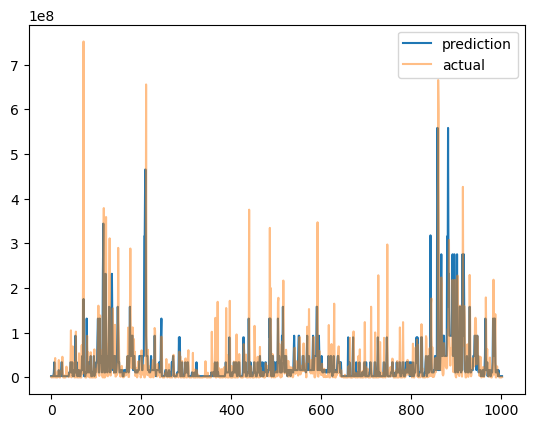

In [67]:
plt.plot(y_pred_val, label = 'prediction')
plt.plot(y_val.values.squeeze(), alpha = 0.5, label = 'actual')
plt.legend()